# Analyzing an Album Store's Sales Figures Using SQL

In this notebook, we examine the sales figures of a fictitious company called Chinook.

## Creating Helper Functions

In [1]:
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

database_path = 'datasets/chinook.db'
def run_query(q):
    with sqlite3.connect(database_path) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(database_path) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type in ("table", "view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The table above displays all of the tables found in the Chinook database.

## A Look at Some Track Genres

In [2]:
track_genres = '''
SELECT name FROM genre LIMIT 10;
'''
run_query(track_genres)

,name
0,Rock
1,Jazz
2,Metal
3,Alternative & Punk
4,Rock And Roll
5,Blues
6,Latin
7,Reggae
8,Pop
9,Soundtrack


## Top 10 Selling Genres

In [3]:
top_ten_genres_query = '''
WITH usa_track_sales AS
    (
    SELECT
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    )
SELECT
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    ROUND(
        (CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
            SELECT COUNT(*) FROM usa_track_sales
        )) * 100
    , 2) percentage_sold
FROM usa_track_sales uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
'''
run_query(top_ten_genres_query)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


Text(0.5, 0, '')

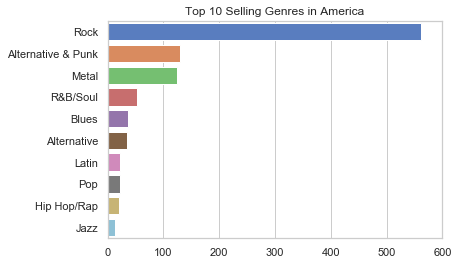

In [4]:
top_ten_genres = run_query(top_ten_genres_query)

sns.set(style='whitegrid')
sns.barplot(
    data=top_ten_genres,
    x='tracks_sold',
    y='genre',
    orient='h',
    palette='muted',
)

plt.xlim((0,600))
plt.title('Top 10 Selling Genres in America')
plt.ylabel('')
plt.xlabel('')


In [5]:
top_ten_genres.loc[top_ten_genres['genre'] != 'Rock', 'genre'] = 'Other'
top_ten_genres.groupby('genre').sum()

,tracks_sold,percentage_sold
genre,,
Other,456,43.38
Rock,561,53.38


In America, 'Rock' outsells all other genres combined by wide margin--about 10 percentage points higher. Because it accounts for the vast majority of sales, special attention should be given to artists and albums in this genre, while giving due attention to 'Alternative & Punk', 'Metal', 'R&B/Soul', and 'Blues' genres, which themselves account for substantial portion of sales.

## Employee Sales Performance

In [6]:
employee_sales_query = '''
WITH customer_purchases AS
    (
    SELECT
        c.*,
        i.*
    FROM invoice i
    INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT
    e.first_name || " " || e.last_name AS employee,
    STRFTIME('%m/%d/%Y', e.hire_date) hire_date,
    SUM(cp.total) total_sales,
    ROUND(
        (SUM(cp.total) / (SELECT SUM(total) FROM invoice) * 100),
    2) sales_percentage,
    ROUND(
        AVG(cp.total),
    2) average_sale,
    ROUND(
        MAX(cp.total),
    2) max_sale
FROM employee e
INNER JOIN customer_purchases cp ON cp.support_rep_id = e.employee_id
WHERE e.title = 'Sales Support Agent'
GROUP BY employee
ORDER BY total_sales DESC;
'''
run_query(employee_sales_query)

,employee,hire_date,total_sales,sales_percentage,average_sale,max_sale
0,Jane Peacock,04/01/2017,1731.51,36.77,8.17,23.76
1,Margaret Park,05/03/2017,1584.00,33.63,7.40,19.80
2,Steve Johnson,10/17/2017,1393.92,29.60,7.41,16.83


Text(0.5, 0, '')

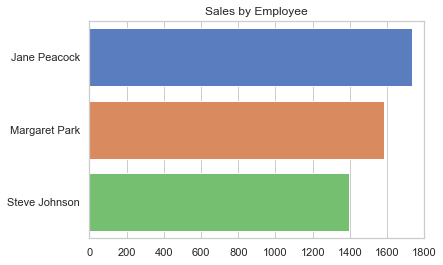

In [7]:
employee_sales = run_query(employee_sales_query)

sns.barplot(
    data=employee_sales,
    x='total_sales',
    y='employee',
    palette='muted'
)

plt.xlim((0,1800))
plt.title('Sales by Employee')
plt.ylabel('')
plt.xlabel('')

Although Jane Peacock has the best sales figures, it most likely due to the fact she has been working longer for the
company.

## Sales by Country

In [8]:
country_sales_query = '''
WITH country_profile AS
    (
    SELECT
        c.customer_id,
        CASE
            WHEN
                (
                SELECT
                    COUNT(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN 'Other'
            ELSE c.country
        END AS country
    FROM customer c
    )
SELECT
    country,
    total_customers,
    total_sales,
    customer_lifetime_value,
    avg_order
FROM (
    SELECT
        cp.country,
        COUNT(DISTINCT cp.customer_id) total_customers,
        SUM(i.total) total_sales,
        ROUND(SUM(i.total) / COUNT(DISTINCT cp.customer_id),3) customer_lifetime_value,
        ROUND(AVG(i.total),3) avg_order,
        CASE
            WHEN cp.country = 'Other' THEN 1
            ELSE 0
        END AS sort
    FROM country_profile cp
    INNER JOIN invoice i ON i.customer_id = cp.customer_id
    GROUP BY cp.country
)
ORDER BY sort ASC, total_sales DESC;
'''

run_query(country_sales_query)

,country,total_customers,total_sales,customer_lifetime_value,avg_order
0,USA,13,1040.49,80.038,7.943
1,Canada,8,535.59,66.949,7.047
2,Brazil,5,427.68,85.536,7.011
3,France,5,389.07,77.814,7.781
4,Germany,4,334.62,83.655,8.161
5,Czech Republic,2,273.24,136.620,9.108
6,United Kingdom,3,245.52,81.840,8.769
7,Portugal,2,185.13,92.565,6.384
8,India,2,183.15,91.575,8.721
9,Other,15,1094.94,72.996,7.449


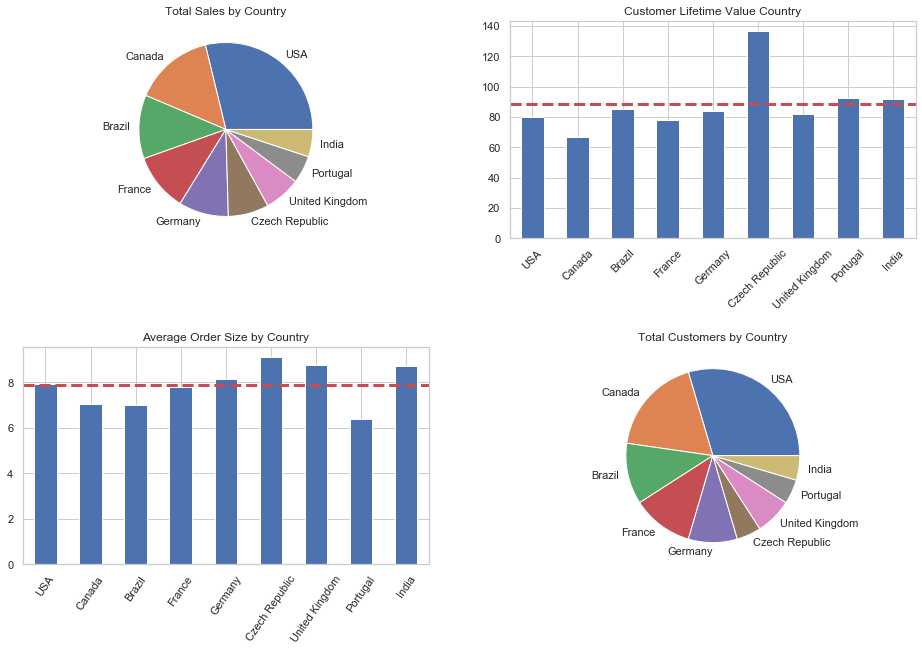

In [9]:
country_profile = run_query(country_sales_query)[:-1]
country_profile.set_index("country", drop=True, inplace=True)

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(16,10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5,wspace=.2)

total_sales = country_profile['total_sales'].copy().rename('')
total_sales.plot.pie(
    ax=ax1,
    title='Total Sales by Country',
)

customer_lifetime_val = country_profile['customer_lifetime_value'].copy().rename('')
customer_lifetime_val.index.name = ''
customer_lifetime_val.plot.bar(
    ax=ax2,
    title='Customer Lifetime Value Country',
    rot=45,
)
ax2.axhline(
    y=customer_lifetime_val.mean(),
    color='r',
    linestyle='--',
    linewidth=3
)

avg_order = country_profile['avg_order'].copy().rename('')
avg_order.index.name = ''
avg_order.plot.bar(
    ax=ax3,
    title='Average Order Size by Country',
    rot=55,
)
ax3.axhline(
    y=avg_order.mean(),
    color='r',
    linestyle='--',
    linewidth=3,
)

total_customers = country_profile['total_customers'].copy().rename('')
total_customers.plot.pie(
    ax=ax4,
    title='Total Customers by Country'
)

* The Czech Republic looks like a profitable market, since its customer lifetime value and average order size lead among all countries. Given its potential for value, special attention should be given to marketing and advertising in the Czech Republic.
    
* Moreover, India and the United Kingdom have average order sizes that exceed the mean by a substantial margin. Although these countries customer lifetime values slightly beat the average, attracting customers in these markets could boost sales in the short-term at the very least.

## Comparing Album and Track Sales

Customers either purchase a bundle of individual tracks or they purchase whole albums. The query below finds the percentages of these types of sales made since the company began to operate.

In [10]:
album_track_sales_query = '''
WITH invoice_some_album AS
    (
    SELECT
        il.invoice_id,
        t.album_id
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    GROUP BY il.invoice_id
    ),
    invoice_album_purchase AS
    (
    SELECT
        i.*,
        CASE
            WHEN 
                (
                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = i.invoice_id
                
                EXCEPT
                
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                    SELECT isa.album_id FROM invoice_some_album isa
                    WHERE isa.invoice_id = i.invoice_id
                )) IS NULL
            AND
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                    SELECT isa.album_id FROM invoice_some_album isa
                    WHERE isa.invoice_id = i.invoice_id
                )
                
                EXCEPT
                
                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = i.invoice_id
                ) IS NULL
            THEN "Yes"
            ELSE "No"
        END AS album_purchase
    FROM invoice i
    )
SELECT
    iap.album_purchase,
    COUNT(iap.album_purchase) total,
    ROUND((CAST(COUNT(iap.album_purchase) AS FLOAT) / (
        SELECT COUNT(*) FROM invoice_album_purchase)) * 100,
    2) percentage
FROM invoice_album_purchase iap
GROUP BY album_purchase
'''

run_query(album_track_sales_query)

,album_purchase,total,percentage
0,No,500,81.43
1,Yes,114,18.57


Clearly, the vast majority of sales were track bundles. Instead of purchasing whole albums to sell, the company should focus on purchasing the most popular tracks of each album and offer these tracks individually, which the customer can bundle as they please.